In [1]:
import os
import torch
from PIL import Image
import trimesh
from utils.zero123_utils import init_model, predict_stage1_gradio, zero123_infer
from utils.sam_utils import sam_init, sam_out_nosave
from utils.utils import pred_bbox, image_preprocess_nosave, gen_poses, image_grid, convert_mesh_format
from elevation_estimate.estimate_wild_imgs import estimate_elev

_GPU_INDEX = 0
_HALF_PRECISION = True
_MESH_RESOLUTION = 256
# NOTE: Uncomment the following line in the docker container
# os.chdir("One-2-3-45/")

In [2]:
def preprocess(predictor, raw_im, lower_contrast=False):
    raw_im.thumbnail([512, 512], Image.Resampling.LANCZOS)
    image_sam = sam_out_nosave(predictor, raw_im.convert("RGB"), pred_bbox(raw_im))
    input_256 = image_preprocess_nosave(image_sam, lower_contrast=lower_contrast, rescale=True)
    torch.cuda.empty_cache()
    return input_256

In [3]:
def stage1_run(model, device, exp_dir,
               input_im, scale, ddim_steps):
    # folder to save the stage 1 images
    stage1_dir = os.path.join(exp_dir, "stage1_8")
    os.makedirs(stage1_dir, exist_ok=True)

    # stage 1: generate 4 views at the same elevation as the input
    output_ims = predict_stage1_gradio(model, input_im, save_path=stage1_dir, adjust_set=list(range(4)), device=device, ddim_steps=ddim_steps, scale=scale)
    
    # stage 2 for the first image
    # infer 4 nearby views for an image to estimate the polar angle of the input
    stage2_steps = 50 # ddim_steps
    zero123_infer(model, exp_dir, indices=[0], device=device, ddim_steps=stage2_steps, scale=scale)
    # estimate the camera pose (elevation) of the input image.
    try:
        polar_angle = estimate_elev(exp_dir)
    except:
        print("Failed to estimate polar angle")
        polar_angle = 90
    print("Estimated polar angle:", polar_angle)
    gen_poses(exp_dir, polar_angle)

    # stage 1: generate another 4 views at a different elevation
    if polar_angle <= 75:
        output_ims_2 = predict_stage1_gradio(model, input_im, save_path=stage1_dir, adjust_set=list(range(4,8)), device=device, ddim_steps=ddim_steps, scale=scale)
    else:
        output_ims_2 = predict_stage1_gradio(model, input_im, save_path=stage1_dir, adjust_set=list(range(8,12)), device=device, ddim_steps=ddim_steps, scale=scale)
    torch.cuda.empty_cache()
    return 90-polar_angle, output_ims+output_ims_2
    
def stage2_run(model, device, exp_dir,
               elev, scale, stage2_steps=50):
    # stage 2 for the remaining 7 images, generate 7*4=28 views
    if 90-elev <= 75:
        zero123_infer(model, exp_dir, indices=list(range(1,8)), device=device, ddim_steps=stage2_steps, scale=scale)
    else:
        zero123_infer(model, exp_dir, indices=list(range(1,4))+list(range(8,12)), device=device, ddim_steps=stage2_steps, scale=scale)

def reconstruct(exp_dir, output_format=".ply", device_idx=0):
    exp_dir = os.path.abspath(exp_dir)
    main_dir_path = os.path.abspath(os.path.dirname("./"))
    os.chdir('reconstruction/')

    bash_script = f'CUDA_VISIBLE_DEVICES={device_idx} python exp_runner_generic_blender_val.py \
                    --specific_dataset_name {exp_dir} \
                    --mode export_mesh \
                    --conf confs/one2345_lod0_val_demo.conf \
                    --resolution {_MESH_RESOLUTION}'
    print(bash_script)
    os.system(bash_script)
    os.chdir(main_dir_path)

    ply_path = os.path.join(exp_dir, f"mesh.ply")
    if output_format == ".ply":
        return ply_path
    if output_format not in [".obj", ".glb"]:
        print("Invalid output format, must be one of .ply, .obj, .glb")
        return ply_path
    return convert_mesh_format(exp_dir, output_format=output_format)

In [4]:
device = f"cuda:{_GPU_INDEX}" if torch.cuda.is_available() else "cpu"

# initialize the zero123 model
models = init_model(device, 'zero123-xl.ckpt', half_precision=_HALF_PRECISION)
model_zero123 = models["turncam"]

# initialize the Segment Anything model
predictor = sam_init(_GPU_INDEX)

Instantiating LatentDiffusion...

Loading model from zero123-xl.ckpt

Global Step: 122000

LatentDiffusion: Running in eps-prediction mode
DiffusionWrapper has 859.53 M params.
Keeping EMAs of 688.
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 4, 32, 32) = 4096 dimensions.
making attention of type 'vanilla' with 512 in_channels


Instantiating StableDiffusionSafetyChecker...

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


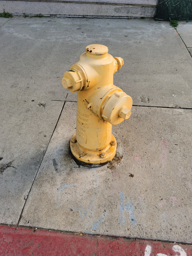

In [5]:
shape_id = "01_wild_hydrant"
example_input_path = f"./demo/demo_examples/{shape_id}.png"
example_dir = f"./exp/{shape_id}"
os.makedirs(example_dir, exist_ok=True)
input_raw = Image.open(example_input_path)
# show the input image
input_raw_copy = input_raw.copy()
input_raw_copy.thumbnail((256, 256))
input_raw_copy

SAM Time: 0.609s


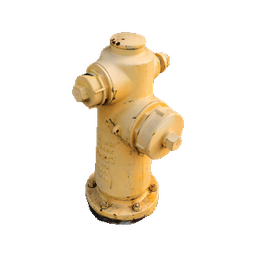

In [6]:
# preprocess the input image
input_256 = preprocess(predictor, input_raw)
input_256

In [7]:
# generate multi-view images in two stages with Zero123.
# first stage: generate N=8 views cover 360 degree of the input shape.
elev, stage1_imgs = stage1_run(model_zero123, device, example_dir, input_256, scale=3, ddim_steps=75)
# second stage: 4 local views for each of the first-stage view, resulting in N*4=32 source view images.
stage2_run(model_zero123, device, example_dir, elev, scale=3, stage2_steps=50)

Data shape for DDIM sampling is (4, 4, 32, 32), eta 1.0
Running DDIM Sampling with 76 timesteps


DDIM Sampler: 100%|██████████| 76/76 [00:03<00:00, 19.80it/s]


Data shape for DDIM sampling is (4, 4, 32, 32), eta 1.0
Running DDIM Sampling with 49 timesteps


DDIM Sampler: 100%|██████████| 49/49 [00:02<00:00, 20.29it/s]
2023-08-18 14:38:21.633 | INFO     | elevation_estimate.utils.elev_est_api:get_feature_matcher:25 - Loading feature matcher...
2023-08-18 14:38:21.779 | INFO     | elevation_estimate.utils.elev_est_api:mask_out_bkgd:48 - Image has no alpha channel, using thresholding to mask out background
2023-08-18 14:38:21.782 | INFO     | elevation_estimate.utils.elev_est_api:mask_out_bkgd:48 - Image has no alpha channel, using thresholding to mask out background
2023-08-18 14:38:21.784 | INFO     | elevation_estimate.utils.elev_est_api:mask_out_bkgd:48 - Image has no alpha channel, using thresholding to mask out background
2023-08-18 14:38:21.787 | INFO     | elevation_estimate.utils.elev_est_api:mask_out_bkgd:48 - Image has no alpha channel, using thresholding to mask out background
2023-08-18 14:38:22.117 | WARNING  | elevation_estimate.utils.elev_est_api:elev_est_api:199 - K is not provided, using default K


Estimated polar angle: 61
Data shape for DDIM sampling is (4, 4, 32, 32), eta 1.0
Running DDIM Sampling with 76 timesteps


DDIM Sampler: 100%|██████████| 76/76 [00:03<00:00, 20.30it/s]


Data shape for DDIM sampling is (4, 4, 32, 32), eta 1.0
Running DDIM Sampling with 49 timesteps


DDIM Sampler: 100%|██████████| 49/49 [00:02<00:00, 20.23it/s]


Data shape for DDIM sampling is (4, 4, 32, 32), eta 1.0
Running DDIM Sampling with 49 timesteps


DDIM Sampler: 100%|██████████| 49/49 [00:02<00:00, 20.18it/s]


Data shape for DDIM sampling is (4, 4, 32, 32), eta 1.0
Running DDIM Sampling with 49 timesteps


DDIM Sampler: 100%|██████████| 49/49 [00:02<00:00, 20.14it/s]


Data shape for DDIM sampling is (4, 4, 32, 32), eta 1.0
Running DDIM Sampling with 49 timesteps


DDIM Sampler: 100%|██████████| 49/49 [00:02<00:00, 20.14it/s]


Data shape for DDIM sampling is (4, 4, 32, 32), eta 1.0
Running DDIM Sampling with 49 timesteps


DDIM Sampler: 100%|██████████| 49/49 [00:02<00:00, 20.08it/s]


Data shape for DDIM sampling is (4, 4, 32, 32), eta 1.0
Running DDIM Sampling with 49 timesteps


DDIM Sampler: 100%|██████████| 49/49 [00:02<00:00, 20.03it/s]


Data shape for DDIM sampling is (4, 4, 32, 32), eta 1.0
Running DDIM Sampling with 49 timesteps


DDIM Sampler: 100%|██████████| 49/49 [00:02<00:00, 19.97it/s]


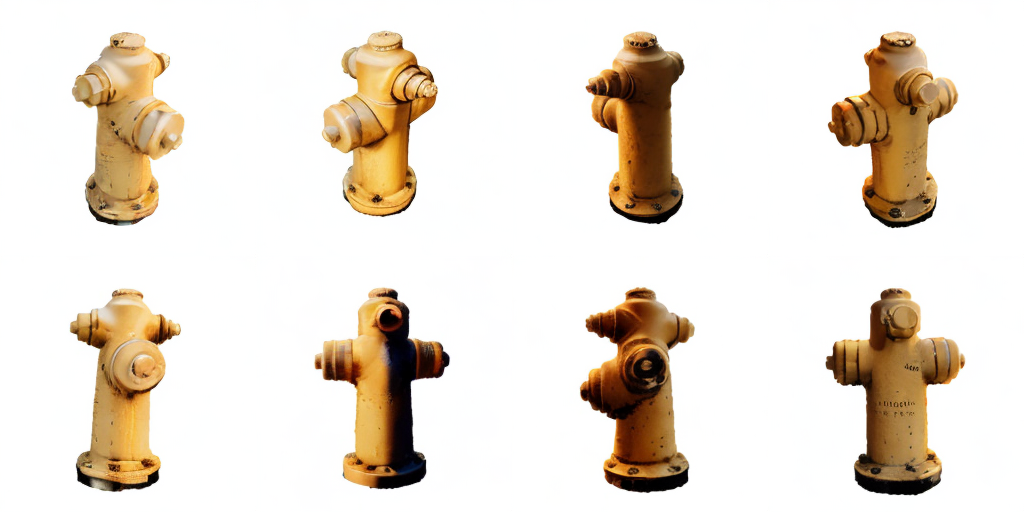

In [8]:
image_grid(stage1_imgs, rows=2, cols=4)

In [9]:
# utilize cost volume-based 3D reconstruction to generate textured 3D mesh
mesh_path = reconstruct(example_dir, output_format=".glb", device_idx=_GPU_INDEX)
print("Mesh saved to:", mesh_path)

CUDA_VISIBLE_DEVICES=0 python exp_runner_generic_blender_val.py                     --specific_dataset_name /home/chao/chao/One2345/One2345/exp/01_wild_hydrant                     --mode export_mesh                     --conf confs/one2345_lod0_val_demo.conf                     --resolution 256
detected 1 GPUs
base_exp_dir: exp/lod0
Store in: /home/chao/chao/One2345/One2345/exp/01_wild_hydrant


[exp_runner_generic_blender_val.py:148 -             __init__() ] Find checkpoint: ckpt_215000.pth
[exp_runner_generic_blender_val.py:489 -      load_checkpoint() ] End
[exp_runner_generic_blender_val.py:561 -          export_mesh() ] Validate begin


iter_step:  215000
export mesh time:  2.5076334476470947
Mesh saved to: /home/chao/chao/One2345/One2345/exp/01_wild_hydrant/mesh.glb


In [10]:
# show the textured mesh
# better viewed in MeshLab
# credit: https://github.com/google/model-viewer/issues/1088#issuecomment-612320218
import panel as pn
pn.extension()

js = """
    <script src="https://unpkg.com/@webcomponents/webcomponentsjs@2.2.7/webcomponents-loader.js"></script>
    <script type="module" src="https://unpkg.com/@google/model-viewer/dist/model-viewer.js"></script>
    <script nomodule src="https://unpkg.com/@google/model-viewer/dist/model-viewer-legacy.js"></script>
"""
js_pane = pn.pane.HTML(js)

# only .glb is supported
html=f"""
    <model-viewer src="./exp/{shape_id}/mesh.glb", alt="A 3D model of textured mesh generated by One-2-3-45"
    auto-rotate camera-controls style="height:100%;width:100%;">
    </model-viewer>
"""

model_viewer_pane = pn.pane.HTML(html, height=800, width=500)

app = pn.Column(js_pane, model_viewer_pane, styles={'background': 'grey'})

app.servable()

BokehModel(combine_events=True, render_bundle={'docs_json': {'37d5e4cc-9b96-4788-9663-3e519bed8579': {'version…